## **Introduction**
The goal of this project is to to use the close price to predict the next day price. I will use the LSTM (Long Short Term memory) and ARIMA models to predict the next day price.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model

#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from textblob import TextBlob 
from wordcloud import WordCloud 

import warnings
warnings.filterwarnings('ignore')

Using Theano backend.


### **Stock Price Trend Analysis for Adjusted Closing Price**
The closing price of a stock is the price of that stock at the close of the trading day. The adjusted closing price uses the closing price as a starting point, but it also takes into account factors such as dividends, stock splits and new stock offerings to determine a value. The adjusted closing price represents a more accurate reflection of a stock's value, since distributions and new offerings can alter the closing price.<br>

In [2]:
"""
Pfizer(PFE)   $51.75 billion.
Roche(RO)    $50 billion.
Novartis(NOVN) $47.45 billion.
Merck(MRK)    $46.84 billion.
GlaxoSmithKline(GSK) $43.54 billion.
Johnson & Johnson(JNJ) $42.1 billion.

Moderna (MRNA)
Novavax (NVAX)
"""
def get_data_plot(ticker=None, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            plt.title("Stock Adjusted Price Historical Data")
            plt.xlabel('Dates')
            plt.ylabel('Stock Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
#             plt.figure(figsize=(12,12))
#             plt.plot(df_1)
#             plt.title("Stock Adjusted Price Historical Data")
#             plt.xlabel('Dates')
#             plt.ylabel('Stock Prices')
#             plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Symbols,PFE,JNJ,NVAX,MRNA,AZN
Date,,,,,
2019-01-02,37.603287,120.959183,39.400002,15.330000,35.559563
2019-01-03,36.551258,119.037086,40.799999,15.500000,36.058155
2019-01-04,37.385921,121.034927,42.799999,16.959999,36.857777
2019-01-07,37.585892,120.258514,45.200001,16.270000,36.481483
2019-01-08,37.759781,123.051704,46.000000,16.950001,35.870007
...,...,...,...,...,...
2020-12-24,36.868916,152.470001,129.339996,123.389999,48.520000
2020-12-28,36.423756,153.190002,116.849998,111.400002,49.380001
2020-12-29,36.651279,154.139999,120.269997,114.389999,49.900002


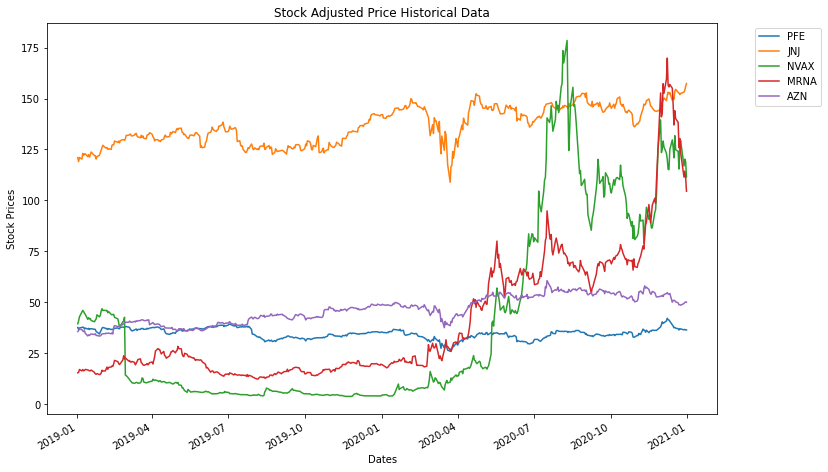

In [3]:
df_1 = get_data_plot(ticker=[['PFE','JNJ','NVAX','MRNA','AZN']], start='2019',end='2021',plot=True, stock_value='Adj Close')
df_1

we will divide each of the rows in the DataFrame by the first row. This will enable comparison across stocks since all stock prices will be shown as a percentage difference over time. A value lower than 1 indicates that the stock price has declined compared to the base date (i.e. 2017–10–04). A value higher than 1 indicates that the price has gone up.<br>
Since prices are shown as a percentage of the first data point, the graph is specially useful to compare price trends from different companies. For example, we can see that NVAX has experienced massive growth in the last few weeks while the other stock prices have been increasing steadily since 2018.

In [4]:
def data_plot(ticker, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        #divide all dataframe by first line of data to enable comparison
        histprice = df_1/df_1.iloc[0]

        if plot==True:
            histprice.plot(figsize=(12,8))
            plt.title("Stock Adjusted Price Historical Data")
            plt.xlabel('Dates')
            plt.ylabel('Stock Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return histprice
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Symbols,PFE,JNJ,NVAX,MRNA,AZN
Date,,,,,
2019-01-02,1.000000,1.000000,1.000000,1.000000,1.000000
2019-01-03,0.972023,0.984110,1.035533,1.011089,1.014021
2019-01-04,0.994220,1.000626,1.086294,1.106327,1.036508
2019-01-07,0.999537,0.994207,1.147208,1.061318,1.025926
2019-01-08,1.004162,1.017299,1.167513,1.105675,1.008730
...,...,...,...,...,...
2020-12-24,0.980471,1.260508,3.282741,8.048924,1.364471
2020-12-28,0.968632,1.266460,2.965736,7.266797,1.388656
2020-12-29,0.974683,1.274314,3.052538,7.461840,1.403279


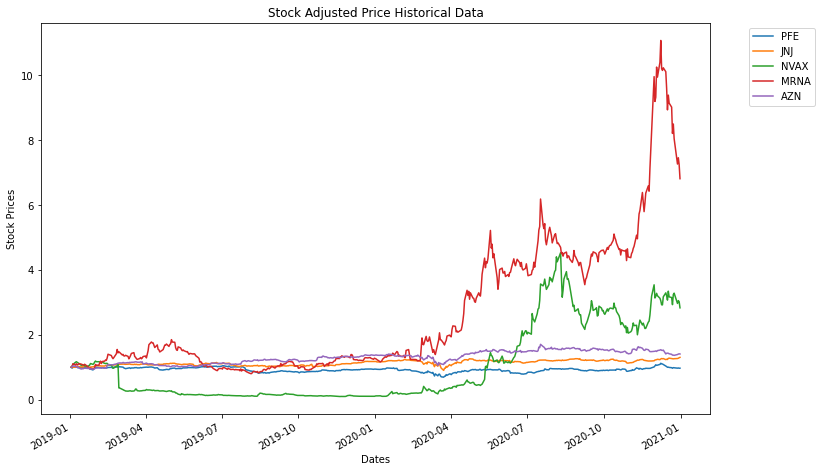

In [5]:
df_2 = data_plot([['PFE','JNJ','NVAX','MRNA','AZN']], plot=True, start='2019',end='2021',stock_value='Adj Close')
df_2

In [6]:
#df_2.to_csv('pharma_stocks.csv')

### Volume

In [7]:
pharma = pd.read_csv('pharma_stocks.csv')
pharma.head()

,Date,PFE,JNJ,NVAX,MRNA,AZN
0,2019-01-02,1.000000,1.000000,1.000000,1.000000,1.000000
1,2019-01-03,0.972023,0.984110,1.035533,1.011089,1.014021
2,2019-01-04,0.994220,1.000626,1.086294,1.106327,1.036508
3,2019-01-07,0.999537,0.994207,1.147208,1.061318,1.025926
4,2019-01-08,1.004162,1.017299,1.167513,1.105675,1.008730


Symbols,PFE,JNJ,NVAX,MRNA,AZN
Date,,,,,
2020-11-02,21430666.0,7088000.0,1855200.0,4650300.0,5368800.0
2020-11-03,21636617.0,6363000.0,1818000.0,4366900.0,4156800.0
2020-11-04,40870536.0,10263500.0,2272300.0,5442100.0,7385800.0
2020-11-05,33926995.0,8016200.0,2233100.0,4449900.0,6660900.0
2020-11-06,23870676.0,5942500.0,1893100.0,5841000.0,3686300.0
2020-11-09,230153864.0,12351600.0,6586500.0,20266800.0,4381300.0
2020-11-10,80091668.0,7386500.0,6854400.0,10499400.0,5835800.0
2020-11-11,58980997.0,6382400.0,3986000.0,18576500.0,4069700.0
2020-11-12,46767877.0,4710300.0,4953400.0,21700100.0,2902900.0


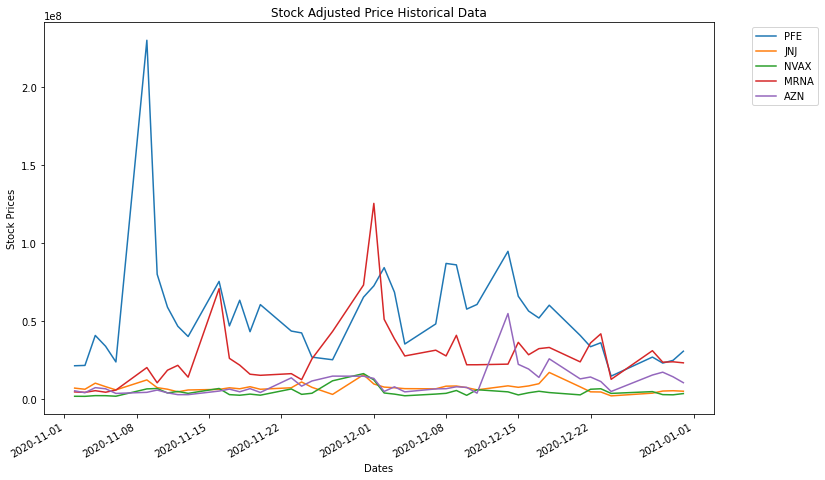

In [8]:
df_vol = get_data_plot(ticker=[['PFE','JNJ','NVAX','MRNA','AZN']], start='2020-11-01',end='2021',plot=True, stock_value='Volume')
df_vol

In [9]:
data_aapl = web.DataReader('MRNA','yahoo','2018','2021')
data_aapl['Price Change'] = data_aapl['Adj Close'].diff()
data_aapl.dropna()

,High,Low,Open,Close,Volume,Adj Close,Price Change
Date,,,,,,,
2018-12-10,19.438999,18.000000,18.900000,18.799999,4233300,18.799999,0.199999
2018-12-11,20.660000,17.990000,20.549999,18.010000,3435300,18.010000,-0.789999
2018-12-12,19.480000,18.020000,18.549999,18.680000,2590700,18.680000,0.670000
2018-12-13,19.290001,18.680000,19.250000,18.760000,1608600,18.760000,0.080000
2018-12-14,18.881001,18.250000,18.750000,18.320000,746300,18.320000,-0.440001
...,...,...,...,...,...,...,...
2020-12-24,129.699997,122.720001,125.940002,123.389999,12720600,123.389999,-6.949997
2020-12-28,122.879997,111.050003,120.040001,111.400002,31088200,111.400002,-11.989998
2020-12-29,116.250000,106.879997,107.795998,114.389999,23718800,114.389999,2.989998


## 2  Daily Price Change

In [ ]:
def diff_data_plot(ticker, plot=True):
 
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo','2018','2021')['Adj Close']
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1_diff = df_1.diff()
            df_1_diff.plot(figsize=(12,8))
            plt.title("Historical Stock Price Change")
            #plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
            plt.xlabel('Dates')
            plt.ylabel('Stock Prices USD ($)')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1_diff
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'
            

In [ ]:
diff_data_plot([['PFE','JNJ','NVAX','MRNA','AZN']], plot=True)
diff_data_plot

## Twitter/Sentiment Analysis
Below are the twitter feeds regarding the pharmaceutical companies and corresponding sentiment analysis of the feeds.<br>

In [ ]:
import json
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 

In [ ]:
with open('/Users/davidtorres/.secret/config_Mod_5.json') as file:
    json_data = json.load(file)

In [ ]:
authenticate = tweepy.OAuthHandler(json_data['consumer_key'],json_data['consumer_secret_key'])
authenticate.set_access_token(json_data['access_token'], json_data['access_token_secret'])

In [ ]:
api = tweepy.API(authenticate, wait_on_rate_limit= True)
#api = tweepy.API(authenticate, wait_on_rate_limit= True)
#api = tweepy.API(authenticate, wait_on_rate_limit= True)
posts = api.user_timeline(screen_name='@JNJNEWS', count=100, lang='en', tweet_mode='extended')
#tweets = api.user_timeline(screen_name='whoever', count=5, tweet_mode='extended')


In [ ]:
def get_tweets(posts):
    tweet_list = []
    for twt in posts:
        tweet_list.append(twt._json)
    tweet_data = pd.DataFrame.from_records(tweet_list)#tweet_df = tweet_data[['created_at','full_text']]
    tweet_df = tweet_data[['created_at','full_text']]
    tweet_df['Date'] = pd.to_datetime(tweet_df['created_at'])
    tweet_df['Date'] = pd.to_datetime(tweet_df['Date'], format='%Y:%m:%d').dt.date
    tweet_df.set_index(["Date"], inplace = True) 
    tweet_df.drop('created_at',axis=1,inplace=True)
    return tweet_df

In [ ]:
tweets_df = get_tweets(posts)
tweets_df

In [ ]:
#clean the text
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text) #r-tells python that expression is a raw tring, once we find substitute fo empty string
  #get rid of any hashtag or number sign
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+','', text)  #retweets followed by 1 or more white spaces
    #remove the hyper link
    text = re.sub(r'https?:\/\/\S+','', text)      #may have 0 or 1 s character
    
    return text

In [ ]:
#cleaning hte text
tweets_df['full_text'] = tweets_df['full_text'].apply(cleanTxt)

In [ ]:
tweets_df

In [ ]:
allWords = ' '.join([twts for twts in tweets_df['full_text']])
wordCloud = WordCloud(width=700, height=500, random_state=21,max_font_size=110).generate(allWords)
plt.imshow(wordCloud,interpolation='bilinear')

In [ ]:
#get subjectivity (how subjective or opinated text is)and pularity (how postive or negative text is)
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [ ]:
#create 2 new columns
tweets_df['Subjectivity'] = tweets_df['full_text'].apply(getSubjectivity)
tweets_df['Polarity'] = tweets_df['full_text'].apply(getPolarity)

In [ ]:
def getAnalysis(score):
    #function to calculate the negative, neutral and positve analysis
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [ ]:
#polarity is the score and going to apply the  function
tweets_df['Analysis'] = tweets_df['Polarity'].apply(getAnalysis)

In [ ]:
tweets_df.head()

## Technical Indicators for Quantative Trading
1. Simple Moving Average
2. Average True Range

### Simple Moving Average
Simple Moving Average is one of the most common technical indicators.  SMA calculates the average of prices over a given interval of time and is used to determine the trend of the stock.<br>
The most commonly used moving averages are the 5-day, 10-day, 20-day, 50-day, and the 200-day moving averages.<br>
SMA takes hte prcie of stock over a certain number of periods and averages the price together. This is useful when trying to identify trends. Sometimres we can identify these trend changes when the SMA closing price drops over.  What this means for a ninvestor is that the closing price differes greatly frm the simple moving averageso it may be time to buy or sell as stock.<br>

In [ ]:
df_sma = get_data_plot(['TSLA'], plot=True, start='2019',end='2021',stock_value='Adj Close')
df_sma

In [ ]:
"""
program uses the 3 moving averages crossoever stategy to determine when to buy and sell stock. 
calculate 3 moving averages
"""
#short or fast exponential moving average
shortEMA = df_sma['Adj Close'].ewm(span=5, adjust=False).mean()
#calcualte middle/medium exponential moving average
middleEMA = df_sma['Adj Close'].ewm(span=21, adjust=False).mean()
#calculte long/slow exponential moving average
longEMA= df_sma['Adj Close'].ewm(span=63, adjust=False).mean()

In [ ]:
#visualize adj closing pprice and exponential moving averages

In [ ]:
"""
concerned w/crossing of exponential averages
this strategy tells us when to buy and when to sell the stock
"""
pd.options.plotting.backend = "plotly"
df_sma.plot(template='plotly_dark')

plt.figure(figsize=(12,6))
plt.plot(df_sma['Adj Close'],label='Adj Close',color='blue')
plt.plot(shortEMA, label='Short/Fast',color='red')
plt.plot(middleEMA,label='Middle',color='orange')
plt.plot(longEMA,label='Long/slow',color='green')


In [ ]:
pd.options.plotting.backend = "plotly"
df_sma.plot(template='plotly_dark')
# fig = px.line(df_sma, x=df_sma.index, y='Adj Close')
# fig = px.line(shortEMA, x=shortEMA.index, y='Adj Close')
# fig

In [ ]:
shortEMA

In [ ]:
import plotly.graph_objs as go

In [ ]:
# fig = px.line(df_sma, x=df_sma.index, y='Adj Close')
# fig.update_layout(title='Productivity, Europe' , showlegend=False)


# # Plotly figure 2
# fig2 = go.Figure(fig.add_traces(
#                  data=px.line(shortEMA, x=shortEMA.index, y='Adj Close')))
# fig2.update_layout(title='Productivity, Europe and America', showlegend=False)

In [ ]:
#calculate when to buy and sell
#add exponential moving averages to teh data set
df_sma['Short'] = shortEMA
df_sma['Middle'] = middleEMA
df_sma['Long'] = longEMA

In [ ]:
df_sma.head()

In [ ]:
#create the function buy and sell stock
def buy_sell_stock(data):
    buy_list = []
    sell_list = []
    flag_long=False  #flags tell which portion of stratgy I'm in
    flag_short=False
    
    for i in range(0,len(data)): #loop through and find all times that strategy applies
        #when to buy stock
        if data['Middle'][i] < data['Long'][i] and data['Short'][i] < data['Middle'][i] and flag_long == False and flag_short == False:
            buy_list.append(data['Adj Close'][i])
            sell_list.append(np.nan)
            flag_short = True
        #when to sell stock
        elif flag_short == True and data['Short'][i] > data['Middle'][i]:
            sell_list.append(data['Adj Close'][i])
            buy_list.append(np.nan)
            flag_short = False  
                                 
        elif data['Middle'][i] > data['Long'][i] and data['Short'][i] > data['Middle'][i] and flag_long == False and flag_short == False:
            buy_list.append(data['Adj Close'][i])
            sell_list.append(np.nan)
            flag_long = True
        #when to sell stock
        elif flag_long == True and data['Short'][i] < data['Middle'][i]:
            sell_list.append(data['Adj Close'][i])
            buy_list.append(np.nan)
            flag_long = False  
        else:
            buy_list.append(np.nan) 
            sell_list.append(np.nan) 
    return (buy_list,sell_list)                             

In [ ]:
#add buy and sell signals to dataset
df_sma['Buy'] = buy_sell_stock(df_sma)[0]
df_sma['Sell'] = buy_sell_stock(df_sma)[1] #return index1

In [ ]:
df_sma.head()

In [ ]:
#visaully show stock buy and sell signals
plt.figure(figsize=(12,6))
plt.title('Buy and Sell Chart')
plt.plot(df_sma['Adj Close'],label='Adj Close',color='blue',alpha=0.35)
plt.plot(shortEMA, label='Short/Fast',color='red',alpha=0.35)
plt.plot(middleEMA,label='Middle',color='orange',alpha=0.35)
plt.plot(longEMA,label='Long/slow',color='green')
plt.scatter(df_sma.index,df_sma['Buy'],color='green',marker='^',alpha=1) #show momentum stock going up
plt.scatter(df_sma.index,df_sma['Sell'],color='red',marker='v',alpha=1) #show momentum stock going up


## **Forecasting**
### Long Short Term Memory (LSTM)

In [ ]:
def get_data(symbol, data_source,start,end):
    df = web.DataReader(symbol,data_source, start, end) 
    #print('Dataset consisits of {} and {}'.format(df[0].shape,df[1].shape))
    df_shape = df.shape
    print('Dataframe consists of {} rows and {} columns'.format(df_shape[0],df_shape[1]))
    
    plt.figure(figsize=(12,8))
    plt.plot(df['Adj Close'])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    return df

In [ ]:
the_data = get_data('MRNA',data_source='yahoo', start='2019-01-01',end='2021-1-11')
the_data

In [ ]:
diff_df = the_data.copy()

In [ ]:
#change in price for day
#radio button or drop down
the_data.diff()['Adj Close'].plot()

In [ ]:
diff_df['Prct_Change'] = the_data.diff().dropna()['Adj Close']

In [ ]:
diff_df.head()

In [ ]:
#df = pd.read_csv('data/apple_2012_1_1-2019_12_17.csv', parse_dates=True, index_col=[0])

#Get the stock quote 
#df = web.DataReader('TGT', data_source='yahoo', start='2016-01-01', end='2021-1-11') 

In [ ]:
#df = df.diff().dropna() #zip_df[11226].diff().dropna()

In [ ]:
def preprocessing(df,percentage):
    training_data_len = int(np.round(len(df) * percentage))
    dataset = pd.DataFrame(df)
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_data = scaler.fit_transform(dataset)
    return training_data_len, dataset, scaler, scaled_data

In [ ]:
#training_data_len, dataset, scaler, scaled_data = preprocessing(df['Close'], percentage=.8)
training_data_len, dataset, scaler, scaled_data = preprocessing(the_data['Adj Close'], percentage=.8)

In [ ]:
def create_sets(training_data_len):
    #create training data set
    train_data = scaled_data[0:training_data_len,:]
    test_data = scaled_data[training_data_len -60:,:] #to 2003 which is end of dataset
    #split data into X_train and y_train data sets
    X_train = []
    y_train = []
    #create dataset X_test and y_test data sets
    X_test = []
    y_test = []    #dataset.iloc[training_data_len:, :]


    for i in range(60, len(train_data)):
        X_train.append(train_data[i-60:i])
        y_train.append(train_data[i,0]) #will contain 61st value which will be at position 60

    for i in range(60, len(test_data)):
        X_test.append(test_data[i-60:i,0]) 
        y_test.append(test_data[i,0])
        
    X_train, y_train = np.array(X_train), np.array(y_train)  
    X_test = np.array(X_test) #added
    X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1)) #added
    y_test = np.array(y_test)
        
    return X_train, X_test, y_train, y_test    

In [ ]:
X_train, X_test, y_train, y_test = create_sets(training_data_len)

In [ ]:
#early_stop = EarlyStopping(monitor='val_loss', patience=2)

def create_model(X_train, y_train):
    model = Sequential()

    model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(units = 25))
    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    model.summary()
    
    return model


In [ ]:

model = create_model(X_train,y_train)

In [ ]:
#callbacks=[early_stop]
early_stop = EarlyStopping(monitor='val_loss', patience=2)
model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop])     

In [ ]:
def save_model():
    model.save('model_parameters')
    model_params = keras.models.load_model('model_parameters')
    model_params.summary()

    return model_params

In [ ]:
model_params = save_model()

In [ ]:
def make_prediction(model, X_test, y_test,training_data_len):
    predictions = model.predict(X_test)
    prediction_unscaled = scaler.inverse_transform(predictions) #unscaling the values
    
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1,1)) #unscaling the values
    
    #this is in dollars
    rmse_predictions = np.sqrt(np.mean(prediction_unscaled -y_test_unscaled)**2)
    rmse_predictions
    
    predictions = pd.DataFrame(prediction_unscaled, columns=['Predictions'])
    
    train = dataset[:training_data_len]
    valid = dataset[training_data_len:] #data from index training_data_len to 
    
    valid.reset_index(inplace=True)
    valid['Prediction'] = predictions['Predictions']
    valid1 = valid.set_index('Date')
    
    plt.figure(figsize=(12,8))
    plt.title('Model')
    plt.xlabel('Label')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train['Adj Close'])
    #plt.plot(valid[['Close','Predictions']])
    plt.plot(valid1['Adj Close'])
    plt.plot(valid1['Prediction'])
    # #valid[['Close','Predictions']].plot()
    plt.legend(['Train','Valid','Predictions'],loc='lower right')
    return rmse_predictions, valid1
    

In [ ]:
make_prediction(model, X_test,y_test, training_data_len )

In [ ]:
from sklearn import metrics

In [ ]:
"""
blue-data model was trainined on 
orange-actual closing stock price for rest of days
green-what model predcited values to be

predict closing price fo TGT stock for 2021-1-11  199.10

get the quote
"""
def get_quote(new_df):
    #get last 60days closing values and convert datframe to an array
    last_60_days = new_df[-60:].values #converts to array
    #scale data
    last_60_days_scaled = scaler.transform(last_60_days)
    #create empty list
    x_test = []
    #append last 60 days to x_test
    x_test.append(last_60_days_scaled)
    #conert x_test to a numpy array
    x_test = np.array(x_test)
    # #reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #get the predicted scaled price
    pred_price = model.predict(x_test)
    #undo the scaling 
    pred_price = scaler.inverse_transform(pred_price) 
    #what model thinks predicted price will be for 12/18/2019
    #the actual prcie was $69.94
    #DAL: 58.58, 2021-1-11 40.19
    return pred_price                    

In [ ]:
get_quote(dataset)

## New Model

In [ ]:
# the_data = get_data('AMZN',data_source='yahoo', start='2016-01-01',end='2021-1-11')
# the_data
# df_1 = get_data_plot(['AZN'], plot=True, start='2019',end='2021',stock_value='Adj Close')
# df_1
the_data_1 = get_data('TGT',data_source='yahoo', start='2019-01-01',end='2021-1-11')
the_data_1

In [ ]:
training_data_len, dataset, scaler, scaled_data = preprocessing(the_data_1['Adj Close'], percentage=.8)

In [ ]:
X_train, X_test, y_train, y_test = create_sets(training_data_len)

In [ ]:
model_params.summary()

In [ ]:
#model.fit(X_train,y_train, epochs=50,batch_size=32,callbacks=[early_stop])  

In [ ]:
make_prediction(model_params, X_test,y_test, training_data_len )

In [ ]:
get_quote(dataset)

## SARIMA MODEL
A time series is a sequence where we record a metric over regular intervals.  Forecasting is the future value that this sequence will take.<br>
An ARIMA model is a forecasting algorithm that takes in previous past values to predict future values.  ARIMA models use past performance to predict future performance.  Based on its own lag and lag errors.  A SARIMA model is an ARIMA model with a seasonality component.<br>

In [ ]:
"""
ARIMA is a forecasting model based on idea that information of past values may be indicative of future values.
ARIMA explains a ts based on its own past values, basically its own lags and lagged forecast errors.
"""
# df_2 = web.DataReader('MRNA','yahoo','2019','2021')
# df_2
# df_1 = get_data_plot(ticker='AMZN', start='2019',end='2021',plot=True, stock_value='Adj Close')
# df_1
# data_sarima = get_data('MRNA',data_source='yahoo', start='2019-01-01',end='2021-1-11')
# data_sarima
the_data_1

In [ ]:
#type(df_2)

In [ ]:
#df_data = df_2.copy()
df_data = pd.DataFrame(the_data_1['Adj Close'])

In [ ]:
df_data.head()

In [ ]:
df_data.info()

## Train Test Split

In [ ]:
#training_data_len, dataset, scaler, scaled_data = preprocessing(df_data['Adj Close'], percentage=.8)
n = int(len(df_data) * 0.8)
train = df_data[:n]
test = df_data[n:]

In [ ]:
#1265
len(train), len(test)

In [ ]:
train.head()

In [ ]:
plt.plot(df_data.index, df_data["Adj Close"])

In [ ]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

In [ ]:
"""
Need to find optimal parameters so you can fit ARIMA model.
Forecasting using optimal parameters
"""
def arima_model(df):
    """
    df- dataframe
    function is a gridsearch to get optimal p,d,qs and lowest AIC for the model.
    q-is moving average
    """
    autoarima_model = auto_arima(df, start_p = 0, start_q = 0, #start_q = 0
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = None,               # let model determine 'd', was 1
                              seasonal = True, 
                              start_P=0, D=1, trace = False, #start  #trace= True
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    #print('\n')
    #display(autoarima_model.summary())
    
    return autoarima_model


In [ ]:
train.shape, test.shape

In [ ]:
stepwise_fit = arima_model(train['Adj Close'])

In [ ]:
stepwise_fit.summary()

In [ ]:
arima_list = [['zipcode', 'pdq','seasonal_pdq','aic']] 
for col in df_data.columns:
  zip_test_2 = arima_model(df_data[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

In [ ]:
import statsmodels.api as sm

In [ ]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

In [ ]:
train['Adj Close'][[0,-1]]

In [ ]:
test['Adj Close'][[0,-1]]

In [ ]:
test

In [ ]:
current_zip = 'Adj Close'
zip_params= output_df[output_df['zipcode']==current_zip]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(df_data[current_zip],order=zip_params.pdq.values[0], seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
from matplotlib.pylab import rcParams

In [ ]:
"""

ax = CO2['1990':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()


"""


rcParams['figure.figsize'] = 15, 6
#plt.figure(figsize=(12,5))
# Plot observed values
ax = train['Adj Close']['2019':].plot(label='observed')#
test['Adj Close']['2019':].plot()#label='Test'
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()


In [ ]:
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 =test['Adj Close']['1996':]

# Compute the root mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [ ]:
current_zip = 'Adj Close'
zip_params = output_df[output_df['zipcode']==current_zip]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(df_data[current_zip],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
def prediction_vis(pred_dynamic,pred_dynamic_conf, y):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  ax = y.plot(label='Observed')

  # Plot predicted values
  pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(pred_dynamic_conf.index,
                  pred_dynamic_conf.iloc[:, 0],
                  pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Sale Price')
  plt.legend()

  return ax

In [ ]:
prediction_visual = prediction_vis(pred_dynamic,pred_dynamic_conf,train[current_zip])
prediction_visual

In [ ]:
# Get the real and predicted values
forecast_11238 = pred_dynamic.predicted_mean
truth_11238 = train[current_zip]#['1996':]

# Compute the mean square error
mse = ((forecast_11238 - truth_11238) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast_11238 - truth_11238) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))